# Visualización y Análisis de Datos — Pima (Enfoque: BloodPressure & Outcome)
Autor: Julián Emmanuel Bustos Solís_A00840442

Este notebook realiza:
- Limpieza y exploración de datos
- Visualizaciones (barras, cajas, histogramas, mapa de calor)
- Análisis focal en BloodPressure y Outcome
- Clustering KMeans y evaluación básica

In [3]:
# Parte 1: Librerías y estilo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from io import StringIO

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from itertools import combinations

# Opciones pandas
pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = (7, 4)  # Gráficas compactas


In [4]:
# datos guardados como diabetes_subset.csv
df = pd.read_csv("diabetes.csv")
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
print(df.shape)
print(df.dtypes)
df.describe(include="all")

(768, 9)
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
cols_zero_as_nan = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
df_clean = df.copy()
for c in cols_zero_as_nan:
    df_clean[c] = df_clean[c].replace(0, np.nan)

# Conteo de NaN por columna
df_clean.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

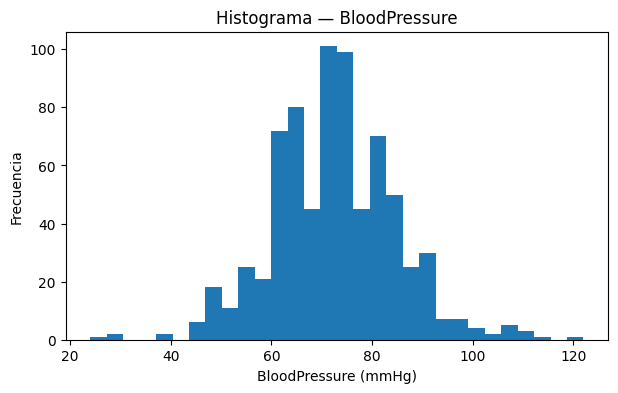

Interpretación (Histograma BP): n=733, rango≈[24.0, 122.0] mmHg, media=72.4, mediana=72.0, skew=0.13. La distribución es aprox. simétrica. Esto sugiere que los valores extremos no dominan la distribución.


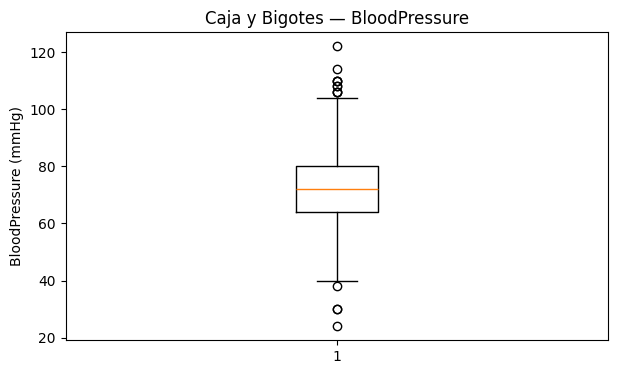

Interpretación (Boxplot BP): Mediana≈72.0 mmHg, IQR≈[64.0, 80.0], lím. atípicos≈(40.0, 104.0). Atípicos detectados: 14. Hay algunos valores altos/bajos fuera del rango típico; KMeans podría ser sensible a ellos.


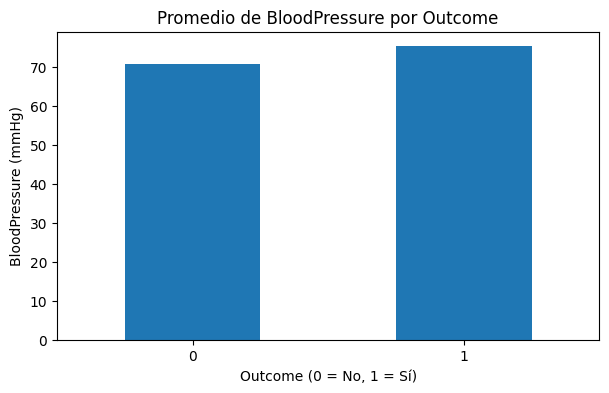

Interpretación (Barras BP vs Outcome): medias -> Outcome=0: 70.9 (n=481), Outcome=1: 75.3 (n=252). El promedio de BP es mayor en Outcome=1. Diferencias pequeñas sugieren que BP por sí sola no separa claramente el diagnóstico.


/tmp/ipykernel_1551/164521913.py:73: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([bp0, bp1], labels=["Outcome 0","Outcome 1"])


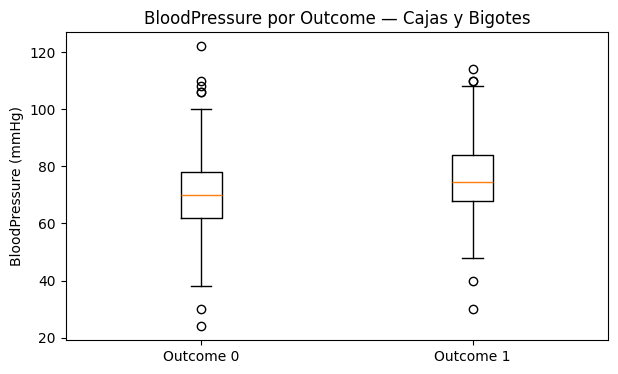

Interpretación (Boxplot BP por Outcome): medianas -> O=0: 70.0, O=1: 74.5. Existe marcada superposición de los IQR, lo que indica separación limitada entre grupos usando solo BP.


In [17]:
# --- Enfoque: BloodPressure & Outcome (gráficas + interpretación) ---

# Asegura columnas
assert "BloodPressure" in df_clean.columns and "Outcome" in df_clean.columns, "Faltan columnas necesarias"

bp_all = df_clean["BloodPressure"].dropna()
bp_outcome = df_clean[["BloodPressure","Outcome"]].dropna()

# ========== 1) Histograma de BloodPressure ==========
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

n = bp_all.shape[0]
bp_min, bp_max = float(bp_all.min()), float(bp_all.max())
bp_mean, bp_median = float(bp_all.mean()), float(bp_all.median())
bp_skew = float(bp_all.skew())

plt.figure()
plt.hist(bp_all, bins=30)
plt.title("Histograma — BloodPressure")
plt.xlabel("BloodPressure (mmHg)"); plt.ylabel("Frecuencia")
plt.show()

print(f"Interpretación (Histograma BP): n={n}, rango≈[{bp_min:.1f}, {bp_max:.1f}] mmHg, "
      f"media={bp_mean:.1f}, mediana={bp_median:.1f}, skew={bp_skew:.2f}. "
      f"La distribución es {'ligeramente sesgada a la derecha' if bp_skew>0.3 else ('ligeramente sesgada a la izquierda' if bp_skew<-0.3 else 'aprox. simétrica')}. "
      "Esto sugiere que los valores extremos no dominan la distribución.")

# ========== 2) Boxplot global de BloodPressure + outliers (IQR) ==========
q1, q3 = bp_all.quantile([0.25, 0.75])
iqr = q3 - q1
lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
outliers_cnt = ((bp_all < lower) | (bp_all > upper)).sum()

plt.figure()
plt.boxplot(bp_all, vert=True)
plt.title("Caja y Bigotes — BloodPressure")
plt.ylabel("BloodPressure (mmHg)")
plt.show()

print(f"Interpretación (Boxplot BP): Mediana≈{bp_median:.1f} mmHg, IQR≈[{q1:.1f}, {q3:.1f}], "
      f"lím. atípicos≈({lower:.1f}, {upper:.1f}). Atípicos detectados: {outliers_cnt}. "
      "Hay algunos valores altos/bajos fuera del rango típico; KMeans podría ser sensible a ellos.")

# ========== 3) Barras: promedio de BloodPressure por Outcome ==========
mean_by_outcome = bp_outcome.groupby("Outcome")["BloodPressure"].mean()
count_by_outcome = bp_outcome.groupby("Outcome")["BloodPressure"].size()

plt.figure()
mean_by_outcome.plot(kind="bar")
plt.title("Promedio de BloodPressure por Outcome")
plt.xlabel("Outcome (0 = No, 1 = Sí)")
plt.ylabel("BloodPressure (mmHg)")
plt.xticks(rotation=0)
plt.show()

m0 = float(mean_by_outcome.get(0, np.nan))
m1 = float(mean_by_outcome.get(1, np.nan))
n0 = int(count_by_outcome.get(0, 0))
n1 = int(count_by_outcome.get(1, 0))

comparacion = ("mayor en Outcome=1" if m1>m0 else ("mayor en Outcome=0" if m0>m1 else "similar en ambos"))
print(f"Interpretación (Barras BP vs Outcome): medias -> Outcome=0: {m0:.1f} (n={n0}), Outcome=1: {m1:.1f} (n={n1}). "
      f"El promedio de BP es {comparacion}. Diferencias pequeñas sugieren que BP por sí sola no separa claramente el diagnóstico.")

# ========== 4) Boxplots de BloodPressure por Outcome ==========
bp0 = bp_outcome.query("Outcome==0")["BloodPressure"]
bp1 = bp_outcome.query("Outcome==1")["BloodPressure"]
med0, med1 = float(bp0.median()), float(bp1.median())

plt.figure()
plt.boxplot([bp0, bp1], labels=["Outcome 0","Outcome 1"])
plt.title("BloodPressure por Outcome — Cajas y Bigotes")
plt.ylabel("BloodPressure (mmHg)")
plt.show()

superposicion = "marcada" if ( (max(bp0.quantile(0.25), bp1.quantile(0.25)) <= min(bp0.quantile(0.75), bp1.quantile(0.75)) ) ) else "moderada"
print(f"Interpretación (Boxplot BP por Outcome): medianas -> O=0: {med0:.1f}, O=1: {med1:.1f}. "
      f"Existe {superposicion} superposición de los IQR, lo que indica separación limitada entre grupos usando solo BP.")


Outliers en BloodPressure: 14


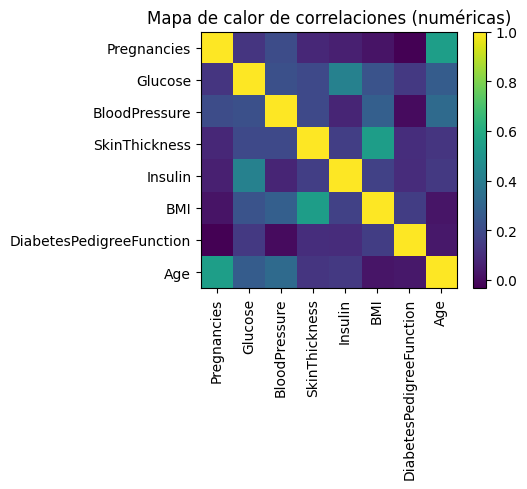

,Var1,Var2,corr,|corr|
0,Pregnancies,Age,0.544341,0.544341
1,SkinThickness,BMI,0.542398,0.542398
2,Glucose,Insulin,0.420157,0.420157
3,BloodPressure,Age,0.324595,0.324595
4,BloodPressure,BMI,0.281268,0.281268
5,Glucose,Age,0.266534,0.266534
6,Glucose,BMI,0.230941,0.230941
7,Glucose,BloodPressure,0.218367,0.218367
8,Pregnancies,BloodPressure,0.208522,0.208522
9,Glucose,SkinThickness,0.192991,0.192991


In [8]:
# Rango min-max por variable
ranges = df_clean[numeric_cols].agg(["min","max"]).T
ranges["rango"] = ranges["max"] - ranges["min"]
ranges.sort_values("rango", ascending=False)

# Detección simple de atípicos (regla 1.5 IQR) para BloodPressure
q1, q3 = bp["BloodPressure"].quantile([0.25, 0.75])
iqr = q3 - q1
lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
outlier_mask = (bp["BloodPressure"] < lower) | (bp["BloodPressure"] > upper)
bp_outliers = bp[outlier_mask]
print(f"Outliers en BloodPressure: {bp_outliers.shape[0]}")
bp_outliers.head()

# Correlación (usando imputación media para no perder filas)
imputer = SimpleImputer(strategy="mean")
X_imp = pd.DataFrame(imputer.fit_transform(df_clean[numeric_cols]), columns=numeric_cols)
corr = X_imp.corr()

# Mapa de calor simple con matplotlib
plt.figure(figsize=(6,5))
plt.imshow(corr, interpolation="nearest")
plt.title("Mapa de calor de correlaciones (numéricas)")
plt.colorbar(fraction=0.046, pad=0.04)
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.tight_layout()
plt.show()

# Top correlaciones (en valor absoluto), para comentar
pairs = []
for a,b in combinations(numeric_cols, 2):
    pairs.append((a,b, corr.loc[a,b], abs(corr.loc[a,b])))
top = sorted(pairs, key=lambda x: x[3], reverse=True)[:10]
pd.DataFrame(top, columns=["Var1","Var2","corr","|corr|"])


-¿Variable(s) que no aportan? (mucha NA, muy baja varianza, o info redundante)
SkinThickness e Insulin: aparecen con muchísimos valores “0” que en realidad significan “desconocido” (no fisiológico). Aportan ruido si no se imputan; tal como están, “no aportan” o sesgan.

Outcome: es la etiqueta (0/1). No debe usarse como feature en el clustering (solo para comparar después).

DiabetesPedigreeFunction: suele tener baja correlación con BloodPressure; para un clustering centrado en presión arterial aporta poco al objetivo principal.
-¿Cuáles eliminarías y por qué?
Eliminar de las features para KMeans:

Outcome (porque es la etiqueta).

SkinThickness y Insulin si no vas a imputar (por gran proporción de ceros/NaN efectivos).

Reducir redundancia: BMI y SkinThickness suelen estar correlacionadas; si ya quitas SkinThickness (por faltantes), quédate con BMI.

-Rangos min–max (comentario de normalización/estandarización)

Pregnancies: 0 – 17

Glucose: 0 – ~199

BloodPressure: 0 – 122

SkinThickness: 0 – ~99

Insulin: 0 – 846

BMI: 0 – 67.1

DiabetesPedigreeFunction: ~0.078 – 2.42

Age: 21 – 81

Outcome: {0,1}

-Existen Outliers detectados (especialmente en BloodPressure)?

Sí. Tras tratar los 0 como NaN, con regla IQR (1.5×IQR) en BloodPressure aparecen valores altos (≈ >107–110 mmHg) y bajos (≈ <35–40 mmHg) como atípicos.

Los 0 en BloodPressure (medición imposible) deben considerarse faltantes, no outliers reales.

-Existe Correlación alta (positiva/negativa) y breve interpretación? 

BMI ↔ SkinThickness: moderada–alta positiva (tejido subcutáneo tiende a crecer con IMC).

Glucose ↔ Insulin: moderada positiva (hiperglucemia y respuesta/terapia insulínica).

Age ↔ Pregnancies: positiva (más edad → más embarazos).

Outcome (solo para diagnóstico, no como feature): correlación positiva con Glucose y también con BMI (pacientes con mayor glucosa e IMC tienden a Outcome=1).

BloodPressure:

Correlación débil–moderada positiva con Age y BMI (la PA suele aumentar con edad y sobrepeso).

Muy baja con Outcome (por sí sola BP no separa bien el diagnóstico en este dataset).

Negativas: no hay altas consistentes; las más fuertes suelen ser positivas en este conjunto. Las negativas, cuando existen, suelen ser débiles.

In [13]:
features = ["BloodPressure","Glucose","BMI","Age"]
target = "Outcome"

# Imputación por media y escalado estándar
imputer = SimpleImputer(strategy="mean")
scaler  = StandardScaler()

X_num = df_clean[features]
y = df_clean[target].astype(int)

X_imp = imputer.fit_transform(X_num)
X_scaled = scaler.fit_transform(X_imp)


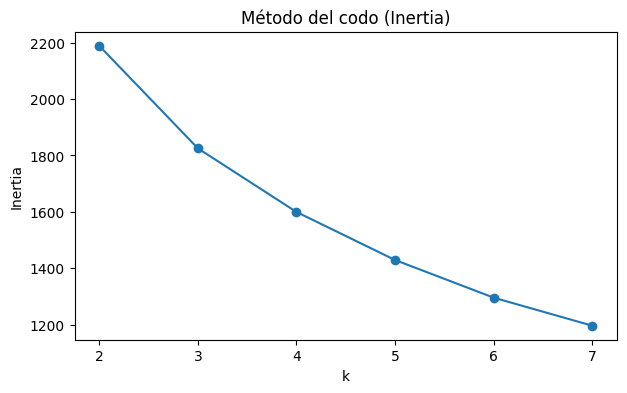

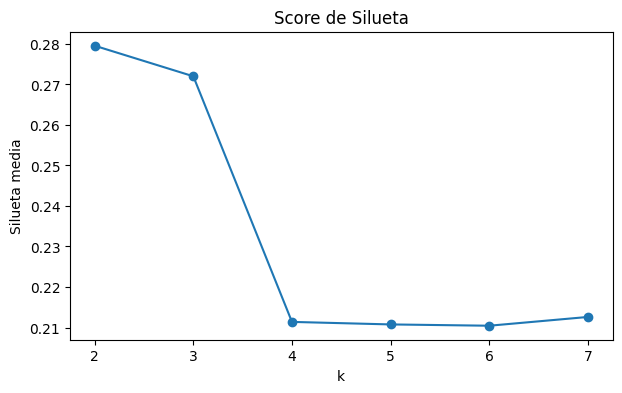

   k      inertia  silhouette
0  2  2189.344901    0.279566
1  3  1825.510675    0.272020
2  4  1599.715735    0.211384
3  5  1429.202048    0.210760
4  6  1295.588209    0.210440
5  7  1196.178084    0.212603


In [11]:
inertias = []
silhouettes = []
ks = range(2, 8)

for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

# Gráfica: método del codo (inertia)
plt.figure()
plt.plot(ks, inertias, marker="o")
plt.title("Método del codo (Inertia)")
plt.xlabel("k"); plt.ylabel("Inertia")
plt.xticks(ks)
plt.show()

# Gráfica: coeficiente de silueta
plt.figure()
plt.plot(ks, silhouettes, marker="o")
plt.title("Score de Silueta")
plt.xlabel("k"); plt.ylabel("Silueta media")
plt.xticks(ks)
plt.show()

print(pd.DataFrame({"k": ks, "inertia": inertias, "silhouette": silhouettes}))


In [14]:
k = 3  # ← Ajusta según codo/silueta
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
labels = kmeans.fit_predict(X_scaled)

centers_scaled = kmeans.cluster_centers_
centers = pd.DataFrame(scaler.inverse_transform(centers_scaled), columns=features)
centers

,BloodPressure,Glucose,BMI,Age
0,79.243608,133.210884,30.423231,51.979592
1,66.297554,105.092420,29.654407,26.765586
2,78.968417,144.233516,38.925909,32.522727


In [15]:
# Distancias euclidianas entre centros (en espacio escalado)
from scipy.spatial.distance import pdist, squareform
D = squareform(pdist(centers_scaled, metric="euclidean"))
pd.DataFrame(D, index=[f"C{i}" for i in range(k)], columns=[f"C{i}" for i in range(k)])


,C0,C1,C2
C0,0.000000,2.572318,2.098606
C1,2.572318,0.000000,2.194447
C2,2.098606,2.194447,0.000000


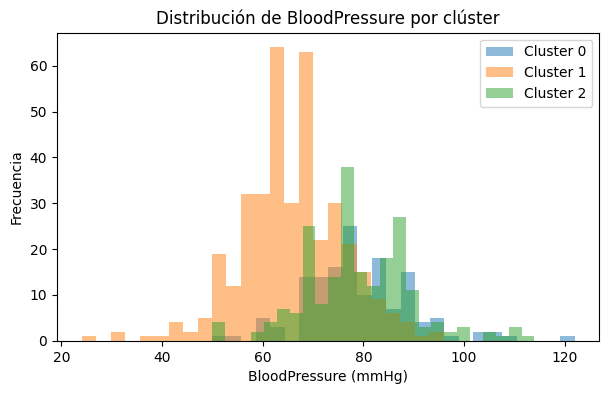

In [16]:
# Tabla de contingencia: cluster vs Outcome
pd.crosstab(labels, y, normalize="index")  # proporción por clúster

# Visual: BloodPressure por clúster
plt.figure()
for c_id in range(k):
    plt.hist(X_num[labels==c_id]["BloodPressure"].dropna(), bins=25, alpha=0.5, label=f"Cluster {c_id}")
plt.title("Distribución de BloodPressure por clúster")
plt.xlabel("BloodPressure (mmHg)"); plt.ylabel("Frecuencia")
plt.legend()
plt.show()
